### Import Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from scipy import stats

### Data Preprocessing

In [2]:
# Load datasets
df1 = pd.read_csv('Data_2004_2013.csv')

# Set the timestamp column as the index
df1['TimeStamp_1'] = pd.to_datetime(df1['TimeStamp_1'], format='mixed')
df1.set_index('TimeStamp_1', inplace=True)

# Train-Test split
# df_train: [2004-11-01 00:00:00 ~ 2007-10-31 23:00:00, 2008-11-01 00:00:00 ~ 2013-10-31 23:00:00]
# df_test: [2007-11-01 00:00:00 ~ 2008-10-31 23:00:00]
split1 = pd.to_datetime('2007-10-31 23:59:00')
split2 = pd.to_datetime('2008-10-31 23:59:00')
split3 = pd.to_datetime('2009-10-31 23:59:00')
df_train = df1[(df1.index < split1) | (df1.index > split2)]
df_test = df1[(df1.index > split1) & (df1.index < split2)]
df_val = df1[(df1.index > split2) & (df1.index < split3)]

# Data normalization
scaled_wave = MinMaxScaler()
scaled_wave = scaled_wave.fit(df_train[['H']])

### Model Evaluation

In [3]:
def shift_probs(probs, shift):
    logits = np.log(probs / (1 - probs)) - shift
    return 1 / (1 + np.exp(-logits))

df_windy = df_val[(df_val.index.month >= 11) | (df_val.index.month <= 3)]
best_shift, lowest_rmse = None, float('inf')

for shift in np.arange(-5, 5.001, 0.001):
    shift_p = shift_probs(df_windy['Spike_prob'], shift)
    y_pred = (1 - shift_p) * df_windy['H_pred0'] + shift_p * df_windy['H_pred1']
    y_pred_raw = scaled_wave.inverse_transform(y_pred.values.reshape(-1, 1))
    y_true = df_windy['H'].values.reshape(-1, 1)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred_raw))
    if rmse < lowest_rmse:
        best_shift, lowest_rmse = shift, rmse

print(f"Windy season best shift: {best_shift:.3f}")

Windy season best shift: 4.132


In [4]:
# Test RMSE
month_mask = (df_test.index.month >= 11) | (df_test.index.month <= 3)
df_test.loc[month_mask, 'Spike_prob'] = shift_probs(df_test.loc[month_mask, 'Spike_prob'], best_shift)
y_pred3 = (1 - df_test['Spike_prob']) * df_test['H_pred0'] + df_test['Spike_prob'] * df_test['H_pred1']
y_pred3_raw = scaled_wave.inverse_transform(y_pred3.values.reshape(-1, 1))
y_true3 = df_test['H']
print(f'Test RMSE: {np.sqrt(mean_squared_error(y_true3, y_pred3_raw)):.3f}')

# Windy season RMSE
df_test1 = df_test[(df_test.index.month >= 11) | (df_test.index.month <= 3)]
y_pred1 = (1 - df_test1['Spike_prob']) * df_test1['H_pred0'] + df_test1['Spike_prob'] * df_test1['H_pred1']
y_pred1_raw = scaled_wave.inverse_transform(y_pred1.values.reshape(-1, 1))
print(f'Windy Season RMSE: {np.sqrt(mean_squared_error(df_test1['H'], y_pred1_raw)):.3f}')

# Calm season RMSE
df_test2 = df_test[(df_test.index.month >= 4) & (df_test.index.month <= 10)]
y_pred2 = (1 - df_test2['Spike_prob']) * df_test2['H_pred0'] + df_test2['Spike_prob'] * df_test2['H_pred1']
y_pred2_raw = scaled_wave.inverse_transform(y_pred2.values.reshape(-1, 1))
print(f'Calm Season RMSE: {np.sqrt(mean_squared_error(df_test2['H'], y_pred2_raw)):.3f}')

Test RMSE: 0.719
Windy Season RMSE: 0.800
Calm Season RMSE: 0.656


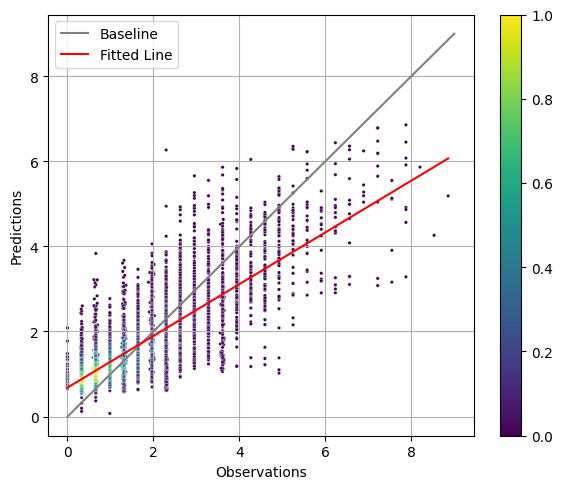

In [ ]:
def pred_vs_obs(y_true, y_pred):
    y_pred = y_pred.flatten()
    fig, ax = plt.subplots(figsize=(6, 5))
    
    ax.plot([0, 9], [0, 9], color='grey', label='Baseline')
    ax.plot(np.unique(y_true), np.poly1d(np.polyfit(y_true,y_pred,1))(np.unique(y_true)), color='r', label='Fitted Line')
    ax.set(xlabel='Observations', ylabel='Predictions')
    ax.legend()
    ax.grid()
    
    kernel = stats.gaussian_kde(np.vstack([y_true, y_pred]))(np.vstack([y_true, y_pred]))
    sns.scatterplot(x=y_true, y=y_pred, c=kernel, s=6, cmap='viridis', ax=ax)
    fig.colorbar(plt.cm.ScalarMappable(cmap='viridis'), ax=ax)
    
    plt.tight_layout()
    plt.show()

pred_vs_obs(y_true3, y_pred3_raw)

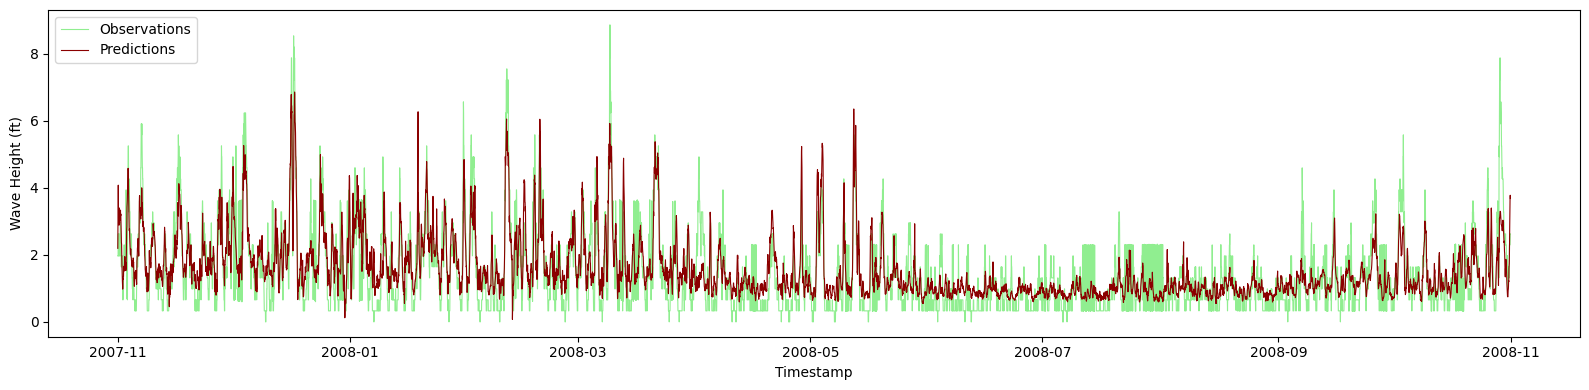

In [ ]:
plt.figure(figsize=(16, 4))
plt.plot(df_test.index, df_test['H'], linewidth=0.8, color='lightgreen', label='Observations')
plt.plot(df_test.index, y_pred3_raw, linewidth=0.8, color='darkred', label='Predictions')

plt.xlabel('Timestamp')
plt.ylabel('Wave Height (ft)')
plt.legend()

plt.tight_layout()
plt.show()